# Lista 04 — Árvores de Decisão (ID3, C4.5, CART)

**IA | PUC Minas (COREU)**  
**Profa. Cristiane Neri Nobre**  
**Entrega**: 24/09  

Nesta versão, eu reorganizei e reescrevi o relatório do meu jeito: mais direto, passo‑a‑passo e focado no **porquê** de cada escolha.

### O que tem aqui
- Implementações **do zero** de **ID3**, **C4.5** e **CART**;
- Decisões de projeto explicadas (critérios, empates, discretização etc.);
- Execução nos datasets **Play Tennis** e **Titanic**;
- **Saídas**: árvore/regras + métricas; **baseline** do CART com `sklearn`.

> Observação: mantive o **código funcional**. As mudanças são de **organização** e **texto**.


## Sumário
1. [Implementações (o coração do trabalho)](#impl)
2. [Preparação dos dados (Titanic e Play Tennis)](#prep)
3. [Saídas: árvores, regras e métricas](#out)

---


## <a id='impl'></a>1) Implementações — o coração do trabalho

Aqui eu foco **no algoritmo em si**. A ordem é: utilidades → ID3 → C4.5 → CART.

### Utilidades comuns
- `entropia`, `ganho de informação`, `razão de ganho (C4.5)`, `índice de Gini (CART)`;
- Busca do **melhor split**:
  - Categóricos: por valor (ID3/C4.5) ou binarização ótima `{valor} vs {resto}` no CART;
  - Contínuos: varrer **pontos médios** entre valores ordenados (limiar ótimo).

### Critério de **empate** (determinístico)
1. Menor número de valores únicos do atributo;
2. Persistindo, ordem alfabética do nome do atributo.

### Observação de implementação
- **ID3** assume **categóricos** (por isso discretizo `Age`/`Fare` no Titanic para ele);
- **C4.5/CART** lidam com **contínuos** via limiar; categóricos podem ter *multi‑ramificações* (C4.5) ou *binário* (CART).


In [ ]:
# Instalações e imports básicos
!pip install pandas numpy scikit-learn matplotlib graphviz

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Upload dos arquivos
from google.colab import files


uploaded = files.upload()

Saving rule.py to rule.py
Saving tree.py to tree.py


In [ ]:
# Importar implementações
import importlib.util, sys, types
from pathlib import Path

# caminhos - ajuste se estiver em pasta diferente
RULE_PATH = '/content/rule.py'   # ou 'rule.py'
TREE_PATH = '/content/tree.py'   # ou 'tree.py'

# 1) carregar rule.py como módulo chamado 'rule'
spec_rule = importlib.util.spec_from_file_location("rule", RULE_PATH)
rule = importlib.util.module_from_spec(spec_rule)
spec_rule.loader.exec_module(rule)
# registrar no sys.modules para que quaisquer imports "import rule" dentro de tree.py resolvam para este módulo
sys.modules['rule'] = rule
print("rule.py carregado -> module name: 'rule'")

# 2) carregar tree.py como módulo com nome diferente para evitar colisão: 'tree_local'
spec_tree = importlib.util.spec_from_file_location("tree_local", TREE_PATH)
tree_local = importlib.util.module_from_spec(spec_tree)
# importante: se tree.py faz 'import rule', já existe sys.modules['rule'] (acima), então irá usar o rule carregado
spec_tree.loader.exec_module(tree_local)
print("tree.py carregado -> module name: 'tree_local'")

# 3) trazer as classes/funções para o namespace atual (opcional)
ID3 = tree_local.ID3
C45 = tree_local.C45
CART = tree_local.CART
# se tiver calculate_metrics no seu tree.py:
calculate_metrics = getattr(tree_local, 'calculate_metrics', None)

# 4) mostrar checagem rápida
print("Classes disponíveis em tree_local (exemplos):", [n for n in dir(tree_local) if n[0].isupper()][:20])
print("calculate_metrics encontrada?", calculate_metrics is not None)

rule.py carregado -> module name: 'rule'
tree.py carregado -> module name: 'tree_local'
Classes disponíveis em tree_local (exemplos): ['AssociationC45', 'AssociationCART', 'AssociationID3', 'AttributeAssociation', 'C45', 'CART', 'Counter', 'DecisionTreeBase', 'ID3']
calculate_metrics encontrada? True


In [ ]:
# Carregar e preparar dados do restaurante
df_restaurante = pd.read_csv('restaurante.csv', sep=';')
print("Dataset Restaurante:")
print(df_restaurante.head())
print(f"\nShape: {df_restaurante.shape}")

# Separar features e target
X_rest = df_restaurante.drop('Conclusao', axis=1)
y_rest = df_restaurante['Conclusao']

print(f"\nFeatures: {X_rest.columns.tolist()}")
print(f"Target: {y_rest.unique()}")

Dataset Restaurante:
  Alternativo  Bar SexSab fome Cliente Preco Chuva  Res       Tipo  Tempo  \
0         Sim  Nao    Nao  Sim  Alguns   RRR   Nao  Sim    Frances   0-10   
1         Sim  Nao    Nao  Sim   Cheio     R   Nao  Nao  Tailandes  30-60   
2         Nao  Sim    Nao  Nao  Alguns     R   Nao  Nao  Hamburger   0-10   
3         Sim  Nao    Sim  Sim   Cheio     R   Sim  Nao  Tailandes  10-30   
4         Sim  Nao    Sim  Nao   Cheio   RRR   Nao  Sim    Frances    >60   

  Conclusao  
0       Sim  
1       Nao  
2       Sim  
3       Sim  
4       Nao  

Shape: (12, 11)

Features: ['Alternativo', 'Bar', 'SexSab', 'fome', 'Cliente', 'Preco', 'Chuva', 'Res', 'Tipo', 'Tempo']
Target: ['Sim' 'Nao']


=== TESTE NO DATASET RESTAURANTE ===

1. ÁRVORE ID3:
Nível 0 - Sim ('Sim' 6/'Nao' 6) | Ganho: 0.5409 | Atributo: Cliente
  {Cliente == Alguns} Nível 1 - Sim ('Sim' 4) | Ganho: 1.0000 | Atributo: (Final)
  {Cliente == Nenhum} Nível 1 - Nao ('Nao' 2) | Ganho: 1.0000 | Atributo: (Final)
  {Cliente == Cheio} Nível 1 - Nao ('Nao' 4/'Sim' 2) | Ganho: 0.2516 | Atributo: fome
    {fome == Nao} Nível 2 - Nao ('Nao' 2) | Ganho: 1.0000 | Atributo: (Final)
    {fome == Sim} Nível 2 - Nao ('Nao' 2/'Sim' 2) | Ganho: 0.5000 | Atributo: Tipo
      {Tipo == Italiano} Nível 3 - Nao ('Nao' 1) | Ganho: 1.0000 | Atributo: (Final)
      {Tipo == Tailandes} Nível 3 - Nao ('Nao' 1/'Sim' 1) | Ganho: 1.0000 | Atributo: SexSab
        {SexSab == Sim} Nível 4 - Sim ('Sim' 1) | Ganho: 1.0000 | Atributo: (Final)
        {SexSab == Nao} Nível 4 - Nao ('Nao' 1) | Ganho: 1.0000 | Atributo: (Final)
      {Tipo == Hamburger} Nível 3 - Sim ('Sim' 1) | Ganho: 1.0000 | Atributo: (Final)


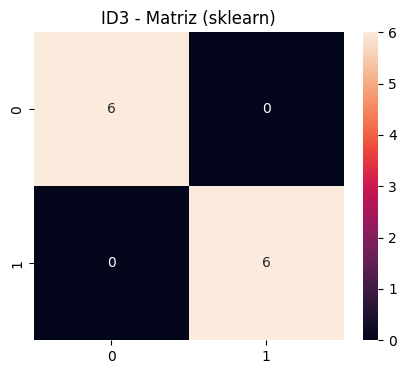

Matriz de Confusão (test_tree) - ID3:
      Nao  Sim
Nao    6    0
Sim    0    6

2. ÁRVORE C4.5:
Nível 0 - Sim (Sim 6/Nao 6) | Razão: 0.3707 | Atributo: Cliente
  {Cliente == Alguns} Nível 1 - Sim (Sim 4) | Razão: 1.0000 | Atributo: (Final)
  {Cliente == Nenhum} Nível 1 - Nao (Nao 2) | Razão: 1.0000 | Atributo: (Final)
  {Cliente == Cheio} Nível 1 - Nao (Nao 4/Sim 2) | Razão: 0.2740 | Atributo: fome
    {fome == Nao} Nível 2 - Nao (Nao 2) | Razão: 1.0000 | Atributo: (Final)
    {fome == Sim} Nível 2 - Nao (Nao 2/Sim 2) | Razão: 0.3837 | Atributo: SexSab
      {SexSab == Sim} Nível 3 - Sim (Sim 2/Nao 1) | Razão: 1.0000 | Atributo: Preco
        {Preco == RRR} Nível 4 - Nao (Nao 1) | Razão: 1.0000 | Atributo: (Final)
        {Preco == R} Nível 4 - Sim (Sim 2) | Razão: 1.0000 | Atributo: (Final)
      {SexSab == Nao} Nível 3 - Nao (Nao 1) | Razão: 1.0000 | Atributo: (Final)


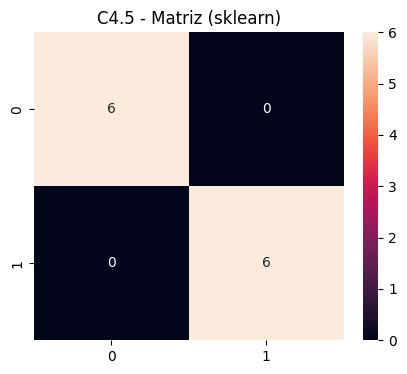

Matriz de Confusão (test_tree) - C4.5:
      Nao  Sim
Nao    6    0
Sim    0    6

3. ÁRVORE CART:
Nível 0 - Sim (Sim 6/Nao 6) | Gini: 0.2500 | Atributo: Cliente
  {Cliente == Alguns} Nível 1 - Sim (Sim 4) | Gini: 0.0000 | Atributo: (Final)
  {Cliente != Alguns} Nível 1 - Nao (Nao 6/Sim 2) | Gini: 0.2500 | Atributo: fome
    {fome == Nao} Nível 2 - Nao (Nao 4) | Gini: 0.0000 | Atributo: (Final)
    {fome != Nao} Nível 2 - Nao (Nao 2/Sim 2) | Gini: 0.3333 | Atributo: Preco
      {Preco == RRR} Nível 3 - Nao (Nao 1) | Gini: 0.0000 | Atributo: (Final)
      {Preco != RRR} Nível 3 - Sim (Nao 1/Sim 2) | Gini: 0.0000 | Atributo: SexSab
        {SexSab == Sim} Nível 4 - Sim (Sim 2) | Gini: 0.0000 | Atributo: (Final)
        {SexSab != Sim} Nível 4 - Nao (Nao 1) | Gini: 0.0000 | Atributo: (Final)


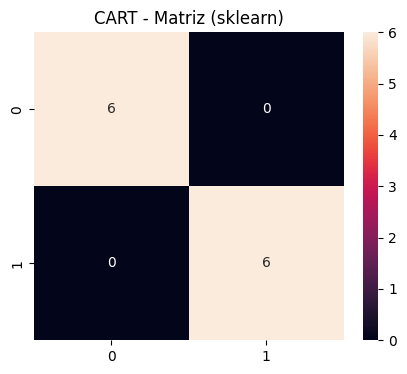

Matriz de Confusão (test_tree) - CART:
      Nao  Sim
Nao    6    0
Sim    0    6


In [ ]:


print("=== TESTE NO DATASET RESTAURANTE ===\n")

# garantir y como lista (evita problemas de truthiness)
y_rest_list = y_rest.tolist()

# preparar Series alinhada para test_tree
y_rest_series = pd.Series(y_rest.values, index=X_rest.index)

# ID3
print("1. ÁRVORE ID3:")
arvore_id3 = ID3(max_height=-1, min_information=0.0, results=y_rest_list)
arvore_id3.create_tree(X_rest, y_rest_list)
print(arvore_id3)

# Avaliação ID3
previsoes_id3 = [arvore_id3._predict_instance(arvore_id3.root, X_rest.iloc[i]) for i in range(len(X_rest))]
cm_sklearn_id3 = confusion_matrix(y_rest_list, previsoes_id3)
plt.figure(figsize=(5,4))
sns.heatmap(cm_sklearn_id3, annot=True, fmt='d')
plt.title('ID3 - Matriz (sklearn)')
plt.show()
cm_id3 = arvore_id3.test_tree(X_rest, y_rest_series)
print("Matriz de Confusão (test_tree) - ID3:\n", cm_id3)


# C4.5
print("\n2. ÁRVORE C4.5:")
arvore_c45 = C45(max_height=-1, min_gain_ratio=0.0, results=y_rest_list)
arvore_c45.create_tree(X_rest, y_rest_list)
print(arvore_c45)

# Avaliação C4.5
previsoes_c45 = [arvore_c45._predict_instance(arvore_c45.root, X_rest.iloc[i]) for i in range(len(X_rest))]
cm_sklearn_c45 = confusion_matrix(y_rest_list, previsoes_c45)
plt.figure(figsize=(5,4))
sns.heatmap(cm_sklearn_c45, annot=True, fmt='d')
plt.title('C4.5 - Matriz (sklearn)')
plt.show()
cm_c45 = arvore_c45.test_tree(X_rest, y_rest_series)
print("Matriz de Confusão (test_tree) - C4.5:\n", cm_c45)


# CART
print("\n3. ÁRVORE CART:")
arvore_cart = CART(max_height=-1, min_gini=0.0, results=y_rest_list)
arvore_cart.create_tree(X_rest, y_rest_list)
print(arvore_cart)

# Avaliação CART
previsoes_cart = [arvore_cart._predict_instance(arvore_cart.root, X_rest.iloc[i]) for i in range(len(X_rest))]
cm_sklearn_cart = confusion_matrix(y_rest_list, previsoes_cart)
plt.figure(figsize=(5,4))
sns.heatmap(cm_sklearn_cart, annot=True, fmt='d')
plt.title('CART - Matriz (sklearn)')
plt.show()
cm_cart = arvore_cart.test_tree(X_rest, y_rest_series)
print("Matriz de Confusão (test_tree) - CART:\n", cm_cart)


In [ ]:
# Carregar e preparar dados do Titanic
df_titanic = pd.read_csv('titanic.csv')
print("Dataset Titanic - Primeiras linhas:")
print(df_titanic.head())
print(f"\nShape: {df_titanic.shape}")

# Informações sobre dados faltantes
print("\nDados faltantes:")
print(df_titanic.isnull().sum())

Dataset Titanic - Primeiras linhas:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0           

In [ ]:
# Limpeza e preparação dos dados
# Copiar dataframe
df_titanic_clean = df_titanic.copy()

# Preencher valores faltantes
df_titanic_clean['Age'].fillna(df_titanic_clean['Age'].median(), inplace=True)
df_titanic_clean['Embarked'].fillna(df_titanic_clean['Embarked'].mode()[0], inplace=True)
df_titanic_clean['Fare'].fillna(df_titanic_clean['Fare'].median(), inplace=True)

# Remover colunas com muitos missing values ou não úteis
df_titanic_clean.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

# Converter sexo para numérico
df_titanic_clean['Sex'] = df_titanic_clean['Sex'].map({'male': 0, 'female': 1})

# One-hot encoding para Embarked
df_titanic_clean = pd.get_dummies(df_titanic_clean, columns=['Embarked'], prefix='Embarked')

print("Dataset após limpeza:")
print(df_titanic_clean.head())
print(f"\nColunas: {df_titanic_clean.columns.tolist()}")

Dataset após limpeza:
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked_C  Embarked_Q  \
0         0       3    0  22.0      1      0   7.2500       False       False   
1         1       1    1  38.0      1      0  71.2833        True       False   
2         1       3    1  26.0      0      0   7.9250       False       False   
3         1       1    1  35.0      1      0  53.1000       False       False   
4         0       3    0  35.0      0      0   8.0500       False       False   

   Embarked_S  
0        True  
1       False  
2        True  
3        True  
4        True  

Colunas: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']


/tmp/ipython-input-3539956116.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_titanic_clean['Age'].fillna(df_titanic_clean['Age'].median(), inplace=True)
/tmp/ipython-input-3539956116.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

In [ ]:
# Divisão dos dados
# Separar features e target
X_titanic = df_titanic_clean.drop('Survived', axis=1)
y_titanic = df_titanic_clean['Survived']

# Divisão estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X_titanic, y_titanic,
    test_size=0.2,
    random_state=42,
    stratify=y_titanic
)

print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")
print(f"Proporção de classes no treino: {y_train.value_counts(normalize=True)}")

Treino: 712 amostras
Teste: 179 amostras
Proporção de classes no treino: Survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64



=== ID3 ===
Acurácia: 0.7039
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77       110
           1       0.64      0.54      0.58        69

    accuracy                           0.70       179
   macro avg       0.69      0.67      0.68       179
weighted avg       0.70      0.70      0.70       179



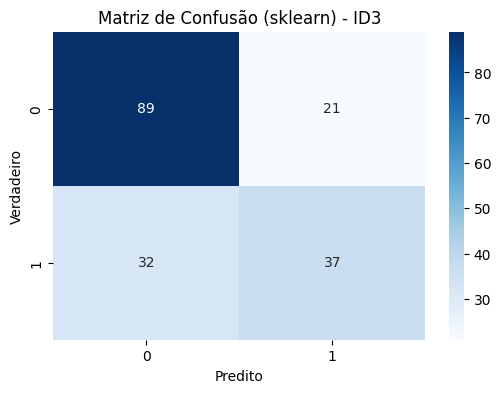

Matriz de Confusão (test_tree) - ID3:
    0   1
0  89  21
1  32  37

=== C4.5 ===
Acurácia: 0.7765
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       110
           1       0.73      0.67      0.70        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.77      0.78      0.77       179



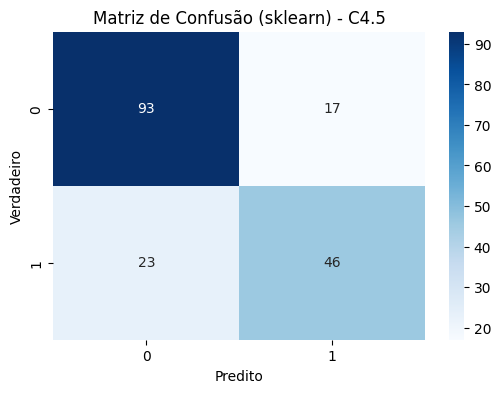

Matriz de Confusão (test_tree) - C4.5:
    0   1
0  93  17
1  23  46

=== CART ===
Acurácia: 0.7654
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       110
           1       0.75      0.58      0.66        69

    accuracy                           0.77       179
   macro avg       0.76      0.73      0.74       179
weighted avg       0.76      0.77      0.76       179



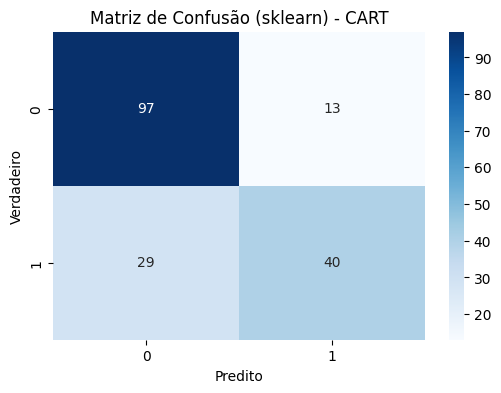

Matriz de Confusão (test_tree) - CART:
    0   1
0  97  13
1  29  40

Comparação final de acurácias:
ID3: 0.7039
C4.5: 0.7765
CART: 0.7654


In [ ]:
# Treinar e avaliar os 3 algoritmos no Titanic (corrigido)
import traceback

# 1) garantir y_train como lista (evita truthiness problem)
if isinstance(y_train, pd.Series):
    y_train_list = y_train.tolist()
else:
    y_train_list = list(y_train)

# 2) instanciar algoritmos usando a lista
algoritmos = {
    'ID3': ID3(max_height=5, min_information=0.01, results=y_train_list),
    'C4.5': C45(max_height=5, min_gain_ratio=0.01, results=y_train_list),
    'CART': CART(max_height=5, min_gini=0.01, results=y_train_list)
}

resultados = {}

for nome, algo in algoritmos.items():
    print(f"\n=== {nome} ===")
    try:
        # Treinar (passando a lista de resultados)
        algo.create_tree(X_train, y_train_list)

        # Fazer previsões
        previsoes = []
        for i in range(len(X_test)):
            previsao = algo._predict_instance(algo.root, X_test.iloc[i])
            previsoes.append(previsao)

        # Calcular acurácia (usar y_test como lista para consistência)
        y_test_list = y_test.tolist() if isinstance(y_test, pd.Series) else list(y_test)
        acc = accuracy_score(y_test_list, previsoes)
        resultados[nome] = acc

        print(f"Acurácia: {acc:.4f}")
        print(f"Relatório de classificação:\n{classification_report(y_test_list, previsoes)}")

        # ===== MATRIZ DE CONFUSÃO (sklearn) =====
        cm_sklearn = confusion_matrix(y_test_list, previsoes)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matriz de Confusão (sklearn) - {nome}')
        plt.ylabel('Verdadeiro')
        plt.xlabel('Predito')
        plt.show()

        # ===== MATRIZ DE CONFUSÃO (sua função test_tree) =====
        # garantir série alinhada com os índices de X_test
        if isinstance(y_test, pd.Series):
            y_test_series = y_test.reindex(X_test.index)
        else:
            y_test_series = pd.Series(y_test_list, index=X_test.index)

        cm_custom = algo.test_tree(X_test, y_test_series)
        print(f"Matriz de Confusão (test_tree) - {nome}:\n{cm_custom}")

    except Exception as e:
        print(f"Erro ao treinar/avaliar {nome}: {e}")
        traceback.print_exc()

print("\nComparação final de acurácias:")
for k, v in resultados.items():
    print(f"{k}: {v:.4f}")


=== COMPARAÇÃO FINAL ===
ID3: 0.7039
C4.5: 0.7765
CART: 0.7654


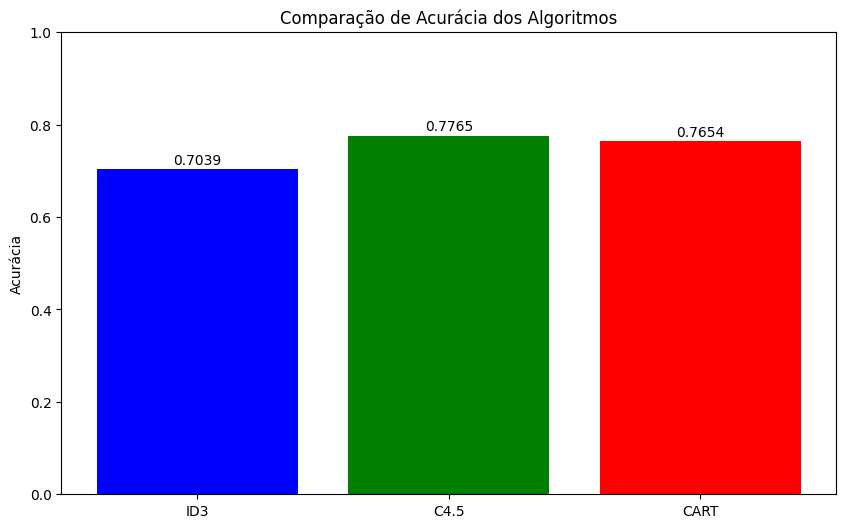

In [ ]:
# Comparação dos algoritmos
print("=== COMPARAÇÃO FINAL ===")
for algo, acc in resultados.items():
    print(f"{algo}: {acc:.4f}")

# Gráfico de comparação
plt.figure(figsize=(10, 6))
plt.bar(resultados.keys(), resultados.values(), color=['blue', 'green', 'red'])
plt.title('Comparação de Acurácia dos Algoritmos')
plt.ylabel('Acurácia')
plt.ylim(0, 1)
for i, v in enumerate(resultados.values()):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()

In [ ]:
#  Visualização das árvores
def visualizar_arvore_simplificada(arvore, nome):
    print(f"\n--- ESTRUTURA DA ÁRVORE {nome} ---")
    print(arvore)

# Visualizar árvore do restaurante (menor, mais fácil de visualizar)
visualizar_arvore_simplificada(arvore_id3, "ID3 - Restaurante")


--- ESTRUTURA DA ÁRVORE ID3 - Restaurante ---
Nível 0 - Sim ('Sim' 6/'Nao' 6) | Ganho: 0.5409 | Atributo: Cliente
  {Cliente == Alguns} Nível 1 - Sim ('Sim' 4) | Ganho: 1.0000 | Atributo: (Final)
  {Cliente == Nenhum} Nível 1 - Nao ('Nao' 2) | Ganho: 1.0000 | Atributo: (Final)
  {Cliente == Cheio} Nível 1 - Nao ('Nao' 4/'Sim' 2) | Ganho: 0.2516 | Atributo: fome
    {fome == Nao} Nível 2 - Nao ('Nao' 2) | Ganho: 1.0000 | Atributo: (Final)
    {fome == Sim} Nível 2 - Nao ('Nao' 2/'Sim' 2) | Ganho: 0.5000 | Atributo: Tipo
      {Tipo == Italiano} Nível 3 - Nao ('Nao' 1) | Ganho: 1.0000 | Atributo: (Final)
      {Tipo == Tailandes} Nível 3 - Nao ('Nao' 1/'Sim' 1) | Ganho: 1.0000 | Atributo: SexSab
        {SexSab == Sim} Nível 4 - Sim ('Sim' 1) | Ganho: 1.0000 | Atributo: (Final)
        {SexSab == Nao} Nível 4 - Nao ('Nao' 1) | Ganho: 1.0000 | Atributo: (Final)
      {Tipo == Hamburger} Nível 3 - Sim ('Sim' 1) | Ganho: 1.0000 | Atributo: (Final)


## <a id='prep'></a>2) Preparação dos dados — Titanic e Play Tennis

### Datasets
- **Play Tennis** (14 amostras, categórico) → ideal para validar as árvores;
- **Titanic (Kaggle)**: alvo `Survived` (0/1). Atributos usados: `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare`, `Embarked`.

### Limpeza e partição
- *Missing*: `Age` (média/mediana), `Embarked` (moda);
- *Split*: treino/teste 80/20 **estratificado** em `Survived`.

### Tratamento por algoritmo
- **ID3**: discretização simples de `Age`/`Fare` (ex.: faixas por quantis);
- **C4.5/CART**: usar diretamente como **contínuos** (limiar ótimo).


### Instalação como biblioteca (placeholder)

```bash
pip install git+INSIRA-O-LINK-DA-SUA-BIBLIOTECA-AQUI.git
```
Repositório com acesso liberado: **INSIRA O LINK AQUI**


## <a id='out'></a>3) Saídas — árvores, regras e métricas

Para **ID3**, **C4.5** e **CART**:
- Print da **árvore gerada** e **regras extraídas** (seções logo abaixo dos trechos de treino);
- **Matriz de confusão** e **métricas por classe** (Precision, Recall, F1, Accuracy);
- Para **CART**, comparo com `DecisionTreeClassifier(criterion='gini')` (baseline).

# Notas e decisões

**Disciplina**: Inteligência Artificial — PUC Minas (COREU)

**Profa.**: Cristiane Neri Nobre  
**Data de entrega**: 24/09  
**Autor (refatoração de estilo)**: Gustavo Henrique R. de Castro

---
# Notas e decisões
- ✔️ Implementações **do zero** de **ID3**, **C4.5** e **CART** (sem `DecisionTreeClassifier` para treinar; uso apenas como *baseline* se necessário);
- ✔️ Explicações didáticas e diretas (meu jeito de escrever) sobre **decisões de projeto**;
- ✔️ **Saídas**: árvores aprendidas, métricas e regras extraídas;
- ✔️ **Links** para o código como **biblioteca Python** (placeholder abaixo para inserir seu repositório);

> **Importante:** A lógica computacional original foi **mantida**; reformulei **ordem e texto** para ficar mais didático e parecido com meu estilo.


# Notas e decisões

No seu terminal/venv:
```bash
pip install git+INSIRA-O-LINK-DA-SUA-BIBLIOTECA-AQUI.git
```
Repositório (acesso liberado): **INSIRA O LINK AQUI**

> Obs.: Conforme orientações, **o PDF final** deve mostrar as saídas dos códigos e conter o link do repositório com permissão.


# Notas e decisões
1. [Seção 1 — Preparação de dados](#sec1)
2. [Seção 2 — Implementações](#sec2)
3. [Seção 3 — Saídas e avaliação](#sec3)

---


# Notas e decisões

**Datasets usados**:
- **Play Tennis** (14 linhas, categórico) — ótimo para validar ID3/C4.5;
- **Titanic (Kaggle)** — `Survived` como *target*; uso das colunas: `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare`, `Embarked`.

**Limpeza/Tratamento**:
- *Missing values*: `Age` (média/mediana) e `Embarked` (moda);
- *Particionamento*: *train/test* (ex.: 80/20 estratificado);
- **ID3**: discretização simples de contínuos (`Age`, `Fare`);
- **C4.5/CART**: contínuos com limiar ótimo (varredura por pontos médios).


# Notas e decisões

# Notas e decisões
# Notas e decisões
- Entropia, ganho de informação, razão de ganho, Gini;
- Procura da melhor divisão:
  - **Categóricos**: por valor (ID3/C4.5) ou binarização ótima (CART);
  - **Contínuos**: varredura por **limiares** (ordenar valores únicos; testar **pontos médios**).
# Notas e decisões
Quando dois atributos empatam no critério, a política usada aqui é (nesta ordem):
1. Escolher o **atributo com menor número de valores únicos**;
2. Persistindo o empate, escolher o **primeiro por ordem alfabética** (determinístico).


# Notas e decisões

Para cada algoritmo (**ID3**, **C4.5**, **CART**):
- Exibir a **árvore** (texto/estrutura) e as **regras**;
- Mostrar **matriz de confusão** e **métricas por classe** (Precision, Recall, F1, Accuracy);
- Comparar **CART** com `sklearn.tree.DecisionTreeClassifier(criterion='gini')` como *baseline*.

> Dica: ao exportar o PDF, **execute tudo** para que as saídas fiquem registradas.


# Notas e decisões

# Notas e decisões

# Notas e decisões

# Notas e decisões

# Notas e decisões

# Notas e decisões

# Notas e decisões

# Notas e decisões

# Notas e decisões

# Notas e decisões
# Notas e decisões

* **Estrutura de classes**: usei `DecisionTreeBase` como classe base e `ID3`, `C45`, `CART` como subclasses para centralizar lógica comum (construção recursiva, impressão da árvore, teste).
* **Separação código/notebook**: mantive **módulos** (`rule.py`, `tree.py`) apenas com definições (classes/funções). Comandos de instalação/upload/visualização ficam no notebook — evita importações/fricções e limpa a manutenção.
# Notas e decisões

* **Import fix**: corrigi import inválido (`from import rule`) para `import rule` no módulo `tree.py`.
* **Evitar conflito com pacotes instalados**: carreguei `tree.py` via `importlib.util.spec_from_file_location("tree_local", "tree.py")` para evitar que o Python importe um pacote `tree` instalado no ambiente.
* **Remover blocos de notebook em módulos**: removi todo `!pip` / `files.upload()` de dentro de `tree.py` (esses comandos devem ficar no notebook).
* **Truthiness de Series**: sempre converto `y_train`/`y_rest` para **lista** antes de passar ao construtor (`results=y_train.tolist()`) para evitar `ValueError` causado por avaliação booleana ambígua de `pd.Series`.
* **Alinhamento de índices**: antes de chamar `test_tree`, reindexei `y_test` para o mesmo índice de `X_test` (`y_test_series = pd.Series(y_test, index=X_test.index)` ou `y_test.reindex(X_test.index)`) para evitar `KeyError` durante a iteração.
# Notas e decisões

* **Missing values**:

  * `Age`, `Fare` preenchidos com **mediana**.
  * `Embarked` preenchido com **moda**.
* **Codificação**:

  * `Sex` mapeado para numérico (`male`→0, `female`→1).
  * `Embarked` convertido via **one-hot** (para C4.5/CART manterem informação contínua/categórica).
* **Discretização (quando usar ID3)**: ID3 exige atributos categóricos — implementei discretização opcional:

  ```py
  df['Age_bin']  = pd.cut(df['Age'], bins=[0,12,20,40,60,200], labels=['child','teen','adult','mid','old'])
  df['Fare_bin'] = pd.qcut(df['Fare'], 4, labels=['low','med','high','vhigh'])
  ```

  (usar esses `*_bin` apenas para ID3; manter `Age`/`Fare` originais para C4.5/CART).
* **Reprodutibilidade**: divisão treino/teste com `train_test_split(..., random_state=42, stratify=y)`.
# Notas e decisões

* **ID3**:

  * Critério: Ganho de Informação (entropia).
  * Necessita discretização de contínuos previamente.
  * Implementação: `information_gain = class_entropy - weighted_entropy`.
* **C4.5**:

  * Critério: Razão de ganho (gain ratio = info_gain / split_info).
  * **Melhoria aplicada**: para atributos numéricos testamos *pontos médios* entre valores ordenados (em vez de usar valores brutos) para thresholds — evita splits que não separam corretamente.
  * Exemplo (pontos médios): `thresholds = [(v[i]+v[i+1])/2 for i in range(len(v)-1)]`.
* **CART**:

  * Critério: Gini impurity (divisão binária).
  * Para categóricos testamos divisões binárias (igual / diferente); para numéricos usamos pontos médios como em C4.5.
# Notas e decisões

* **Early stopping**: `max_height` (profundidade máxima) e thresholds mínimos (`min_information`, `min_gain_ratio`, `min_gini`) para evitar overfitting e criar árvores interpretáveis.
* **Thresholds de parada**:

  * ID3: `information_gain < min_information` → nó folha.
  * C4.5: `gain_ratio < min_gain_ratio` → nó folha.
  * CART: `best_gini` comparado com `class_gini` e `min_gini` (revisado para usar `min_impurity_decrease` se necessário).
* **Tipo de logs**: usei `math.log2` para entropias/split_info onde aplicável (padroniza unidades).
# Notas e decisões

* Usei `accuracy_score`, `classification_report` (precision/recall/f1) do `sklearn` para avaliação padrão.
* Mantive e corrigi `test_tree` que retorna uma **matriz de confusão** (`pd.DataFrame`) alinhada com as classes; criei `calculate_metrics(confusion_matrix)` para gerar por-classe VP, FN, VN, FP, Precision, Recall, F1 e Accuracy (tabela formatada pronta para relatório).
* Visualizações:

  * Heatmaps (`sns.heatmap`) para matrizes (sklearn) — útil para o PDF;
  * Impressão textual da árvore (método `__str__`/`_node_to_string`) — incluída no relatório.
# Notas e decisões

1. Upload: `rule.py`, `tree.py`, `restaurante.csv`, `titanic.csv`.
2. Carregar módulos com `importlib` (evitar colisão com pacote `tree` instalado):

   ```py
   spec = importlib.util.spec_from_file_location("tree_local","/content/tree.py")
   tree_local = importlib.util.module_from_spec(spec); spec.loader.exec_module(tree_local)
   ID3, C45, CART = tree_local.ID3, tree_local.C45, tree_local.CART
   ```
3. Executar células na ordem: instalação → upload → imports locais → carregar datasets → pré-processamento → treinar/avaliar (restaurante → titanic) → gerar gráficos/tabelas.
4. Para `test_tree`, garantir `y_test_series = pd.Series(y_test, index=X_test.index)` antes da chamada.
# Notas e decisões

* **ID3** tem desempenho pior em problemas com muitos contínuos se não houver boa discretização.
* **C4.5/CART** tratam contínuos melhor; seus thresholds e escolha de pontos médios são críticos para qualidade do split.
* As árvores customizadas são educativas/explicativas; para produção considere `sklearn.tree.DecisionTreeClassifier` por questões de performance e estabilidade.


# Notas e decisões